(C) 2024, Gerold Baier, University College London

# Univariate Analysis of sEEG


## Import and Functions

In [1]:
from numpy import pi, linspace, sin, diff, arange, asarray, ndarray, zeros, exp, array, linspace, median, gradient, around
from numpy import triu, triu_indices, triu_indices_from, var, mean, std, sqrt, where, isnan, nan_to_num, delete, floor
from numpy import nan, flip, argwhere, ones, diag, correlate, corrcoef, transpose, cov, flip, ceil, cos, sin, arctan
from numpy import angle, exp, amax, amin, absolute, meshgrid, fill_diagonal, concatenate, c_, real, argsort, tile
from numpy import empty_like, zeros_like, log, logical_and, copy, greater, invert, nonzero, count_nonzero, divide, repeat
from numpy import sign, append, hstack, savetxt, loadtxt, histogram

from numpy.random import normal, permutation
from numpy.linalg import norm

from matplotlib.pyplot import subplots, xlabel, ylabel, hist, bar, legend, axis
from matplotlib.pyplot import figure, xticks, yticks, rcParams, show

from scipy.optimize import curve_fit
from scipy.signal   import butter, sosfilt, find_peaks
from scipy.stats    import spearmanr, entropy
from scipy.spatial  import distance
from scipy.cluster  import hierarchy
from scipy.interpolate import interp1d
from scipy.fft import rfft, rfftfreq

from sklearn.preprocessing import MinMaxScaler

from pandas import read_csv, DataFrame

import pyedflib

from string import ascii_uppercase

from itertools import product

from math import dist


In [2]:
def eeg_plot(data, offset, normalise=True):
    """
    Plot date columns in EEG style
    data:      two-dimensional array
    offset:    scaling factor
    normalise: normalisation of amplitudes to variance 1
    """
    from matplotlib.pyplot import subplots
    
    start      = 0
    samples    = data.shape[0]
    electrodes = data.shape[1]

    dataset = data[start:start+samples, :electrodes]
    means   = data[start:start+samples, :electrodes].mean(axis=0)
    devs    = data[start:start+samples, :electrodes].std(axis=0)

    fig, ax = subplots(figsize=(8, 6))

    if not normalise:
        ax.plot((dataset - means)      + offset*arange(electrodes-1,-1,-1), linewidth=1);
    else:
        ax.plot((dataset - means)/devs + offset*arange(electrodes-1,-1,-1), linewidth=1);
    
    ax.plot(zeros((samples, electrodes)) + offset*arange(electrodes-1,-1,-1),'--',color='gray');
    ax.set(ylabel='Voltage')

    yticks([]);
    
    axis('tight');

    return fig, ax


## Pick Patient, Seizure, Type, and read EEG


In [3]:
# read prefiltered 60 sec segment

folder      = '../Data/'
patient     = '2'         # '1'
seizure     = '02'        # '01' or '02' or '03'
series_type = 'Onset'     # 'Background' or 'Onset' 

sr_chars = folder + 'sampling_rate.txt'

df1 = read_csv(sr_chars, header=None)

sr = df1.iloc[0, 0]

series_chars = folder + 'Sz' + seizure + '_' + series_type + '_B.csv'

df2 = read_csv(series_chars, delimiter=' ', header=None)
df2.head()

data_np = df2.to_numpy()
data_prefiltered = data_np[:, 1:]

all_labels = ['B1-B2', 'B2-B3', 'B3-B4', 'B4-B5', 'B5-B6', 'B6-B7', 'B7-B8', 'B8-B9',
       'B9-B10', 'B10-B11']

print('')
print(series_chars)
print('')


../Data/Sz02_Onset_B.csv



In [6]:
letter_list = list()

for new in all_labels:
    
    if new[0] not in letter_list:
        
        letter_list.append(new[0])


label_dict = dict()

for ind, letter in enumerate(all_labels):
    
    if letter[0] in label_dict.keys():
            pass

    else:
        label_dict[letter[0]] = [ind]   
        
        dict_ind = len(label_dict.keys())
        
        if letter[0] != all_labels[0][0]:
            previous_letter = letter_list[dict_ind - 2]
            label_dict[previous_letter].append(ind)
            
    if ind == len(all_labels)-1:  
        label_dict[letter[0]].append(ind+1)

label_letters = list(label_dict.keys())

label_dict


{'B': [0, 10]}

## Settings and Filtering


In [7]:
band_low  = 1
band_high = 20

order = 5

rows_max        = data_prefiltered.shape[0]
number_channels = data_prefiltered.shape[1]

time_max = rows_max // sr

sample_start = 0

sample_end = sample_start + rows_max



sos = butter(order, (band_low, band_high), btype='bandpass', fs=sr, output='sos')

data_filtered = zeros((rows_max, number_channels))

for index, column in enumerate(data_prefiltered.transpose()): 
    forward = sosfilt(sos, column)
    backwards = sosfilt(sos, forward[-1::-1])
    data_filtered[:, index] = backwards[-1::-1]

data_filtered.shape


(100000, 10)

# A Single Electrode


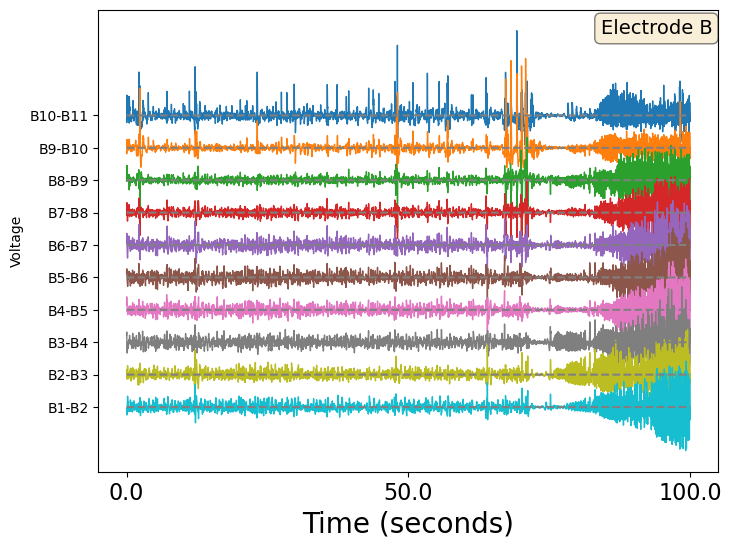

In [8]:
elec_name = 'B'

elec_label_names = all_labels

data_chan      = data_filtered[:, label_dict[elec_name][0]:label_dict[elec_name][1]]

chans = data_chan.shape[1]

factor = 5

fig, ax = eeg_plot(data_chan, factor, normalise=True)
ax.set_yticks(factor*arange(chans))
ax.set_yticklabels(elec_label_names)

ax.set_xticks(linspace(0, rows_max, 3))
labl = linspace(sample_start//sr, sample_start//sr + time_max, 3)
ax.set_xticklabels(labl, fontsize=16)
ax.set_xlabel('Time (seconds)', fontsize=20)

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords
textstr = 'Electrode ' + elec_name
ax.text(0.81, 0.98, textstr, transform=ax.transAxes, fontsize=14,
    verticalalignment='top', bbox=props);

show()


## Pick a Segment and Normalise

In [9]:
seg_start =  60000
seg_stop  = 100000

rows_seg = seg_stop - seg_start

data_chan_seg      = data_chan[seg_start:seg_stop, :]

means              = data_chan_seg.mean(axis=0)
devs               = data_chan_seg.std(axis=0)
data_chan_seg_norm = (data_chan_seg - means)/devs


## Time Series & Heatmap

figs/Sz02_B_timeseries_L1_H20_Start60000.png


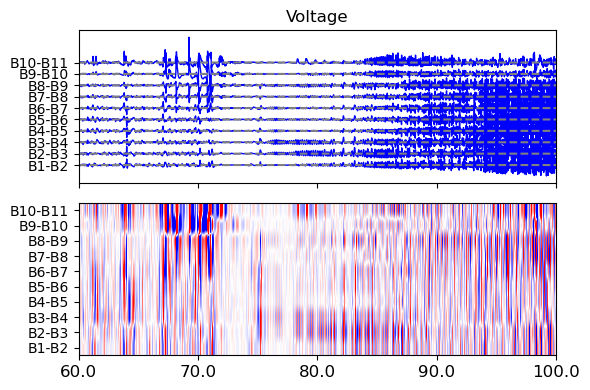

In [10]:
offset = 5

################################### Time Series
fig, (ax1, ax2) = subplots(nrows=2, figsize=(6,4))

### Voltage Series
ax1.plot(data_chan_seg_norm + offset*arange(chans-1,-1,-1), linewidth=1, color='b');
ax1.plot(zeros((rows_seg, chans)) + offset*arange(chans-1,-1,-1),'--',color='gray');
ax1.set_yticks(offset*arange(chans))
ax1.set_yticklabels(elec_label_names)
ax1.margins(x=0)
ax1.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax1.set_xticklabels([], fontsize=12)
ax1.set_title('Voltage', fontsize=12)


### Voltage Heatmap
ax2.imshow(data_chan_seg_norm.T, aspect='auto', cmap='bwr', vmin=-1, vmax=1);
ax2.set_yticks(arange(chans))
ax2.set_yticklabels(flip(elec_label_names));

ax2.set_xticks(linspace(0, rows_seg, 5))
labl =        linspace((sample_start+seg_start)//sr, (sample_start+seg_stop)//sr, 5)
ax2.set_xticklabels(labl, fontsize=12)


fig.tight_layout()

title_chars = 'figs/Sz' + seizure + '_' + elec_name + '_timeseries_' + 'L' + str(band_low) + '_H' + str(band_high) + '_Start' + str(seg_start) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)

show()


## Boxplots of Each Channel

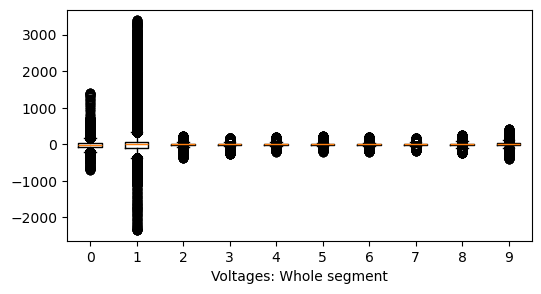

In [11]:
fig, ax = subplots(figsize=(6,3))

ax.boxplot(data_chan_seg);
ax.set_xlabel('Voltages: Whole segment')
ax.set_xticklabels(arange(chans));

show()


## Histograms

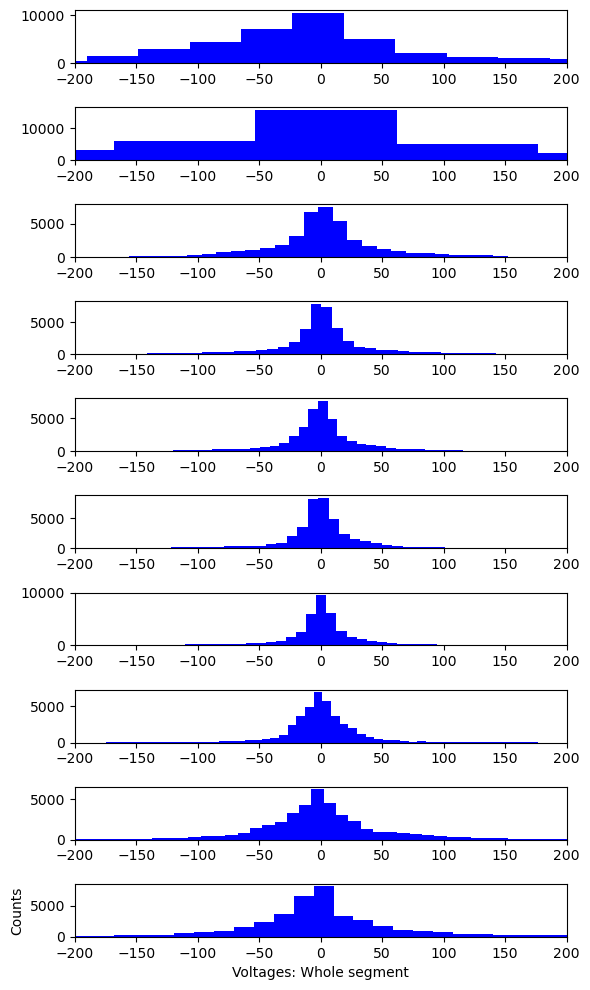

In [12]:
fig, ax = subplots(nrows=chans, figsize=(6,10))

bins = 50

for index in arange(chans):
    
    ax[index].hist(data_chan_seg[:,index], bins=bins, color='b');
    ax[index].set_xlim(-200, 200)
    
ax[-1].set_xlabel('Voltages: Whole segment')
ax[-1].set_ylabel('Counts');

fig.tight_layout()

show()


## The Fourier Spectrum

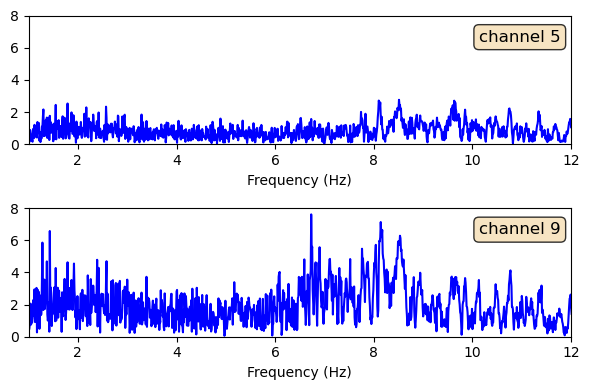

In [13]:
chan1, chan2 = 5, 9

ylim = 8

# frequencies
freqs = rfftfreq(rows_max, 1 / sr)

# amplitude
amplitudes = (2.0 / rows_max)*abs(rfft(data_filtered, axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes[:, chan1], c='b');
ax[0].set_xlim(1, 12);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes[:, chan2], c='b');
ax[1].set_xlim(1, 12);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan1)

ax[0].text(0.83, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan2)

ax[1].text(0.83, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()

show()


## Boxplots & Histograms of Half Segments

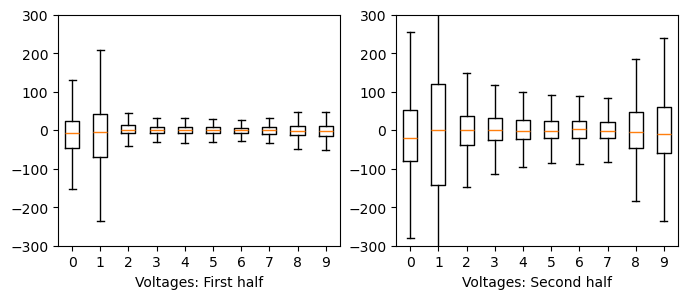

In [14]:
limit = 300

fig, ax = subplots(ncols=2, figsize=(8,3))

ax[0].boxplot(data_chan_seg[:rows_seg//2,:], showfliers=False);
ax[0].set_xticklabels(arange(chans))
ax[0].set_ylim(-limit, limit)

ax[0].set_xlabel('Voltages: First half')

ax[1].boxplot(data_chan_seg[rows_seg//2:,:], showfliers=False);
ax[1].set_xticklabels(arange(chans))
ax[1].set_ylim(-limit, limit)

ax[1].set_xlabel('Voltages: Second half');

show()


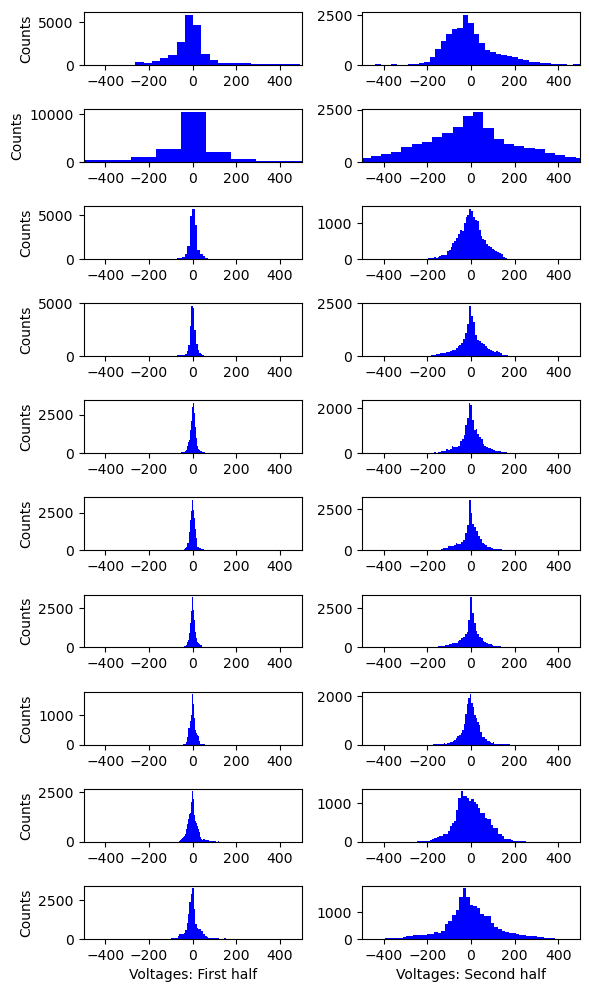

In [15]:
fig, ax = subplots(nrows=chans, ncols=2, figsize=(6,10))

for index in arange(chans):
    
    ax[index, 0].hist(data_chan_seg[:rows_seg//2,index], bins=bins, color='b');
    ax[index, 0].set_ylabel('Counts');
    ax[index, 1].hist(data_chan_seg[rows_seg//2:,index], bins=bins, color='b');
    ax[index, 0].set_xlim(-500, 500)
    ax[index, 1].set_xlim(-500, 500)

ax[-1, 0].set_xlabel('Voltages: First half')
ax[-1, 1].set_xlabel('Voltages: Second half')

fig.tight_layout()

show()


## Fourier spectra of half segments

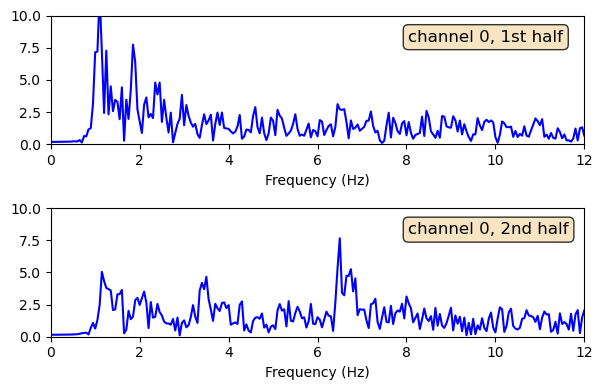

In [16]:
chan = 0

ylim = 10

# frequencies
freqs = rfftfreq(rows_seg//2, 1 / sr)

# amplitude
amplitudes_1 = (2.0 / rows_max)*abs(rfft(data_chan_seg[:rows_seg//2, :], axis=0))
amplitudes_2 = (2.0 / rows_max)*abs(rfft(data_chan_seg[rows_seg//2:, :], axis=0))


fig, ax = subplots(nrows=2, figsize=(6, 4))

ax[0].plot(freqs, amplitudes_1[:, chan], color='b');
ax[0].set_xlim(0, 12);
ax[0].set_ylim(0, ylim);
ax[0].set_xlabel('Frequency (Hz)');

ax[1].plot(freqs, amplitudes_2[:, chan], color='b');
ax[1].set_xlim(0, 12);
ax[1].set_ylim(0, ylim);
ax[1].set_xlabel('Frequency (Hz)');

# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='wheat', alpha=0.8)

# place a text box in upper left in axes coords
textstr = 'channel ' + str(chan) + ', 1st half'

ax[0].text(0.67, 0.89, textstr, transform=ax[0].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

textstr = 'channel ' + str(chan) + ', 2nd half'

ax[1].text(0.67, 0.89, textstr, transform=ax[1].transAxes, fontsize=12,
    verticalalignment='top', bbox=props)

fig.tight_layout()

show()


# Bivariate Analysis

In [17]:
def get_probabilities(data, bins):
    """
    Function to get M probability distributions from an N x M data set
    """

    cnts = zeros(shape=(data.shape[1], bins))

    for index, dat in enumerate(data.T):

        cnt = histogram(dat, bins=bins)[0]

        cnts[index, :] = cnt

    probs = array(cnts)/data.shape[0]
   
    return probs


def jensen_shannon_distance(p, q):
    """
    Function to compute the Jensen-Shannon Distance 
    between two probability distributions
    """

    # calculate m
    m = (p + q) / 2

    # compute Jensen Shannon Divergence
    divergence = (entropy(p, m, base=2) + entropy(q, m, base=2)) / 2

    # compute the Jensen Shannon Distance
    distance = sqrt(divergence)

    return distance
 

In [18]:
# Histogram Similarity
bins = 50

data_probs = get_probabilities(data_chan_seg_norm, bins)

dist_matrix = zeros(shape=(chans, chans))

mat_indices = triu_indices(chans-1)

for ind, num_1 in enumerate(mat_indices[0]):

    num_2 = mat_indices[1][ind]+1
        
    dist = jensen_shannon_distance(data_probs[num_1, :], data_probs[num_2, :])
    
    dist_matrix[num_1, num_2] = dist

data_chan_seg_dist = dist_matrix + triu(dist_matrix).T

data_chan_seg_sim = 1 - data_chan_seg_dist
fill_diagonal(data_chan_seg_sim, 0)

# Correlation
data_chan_seg_corr = corrcoef(data_chan_seg, rowvar=False)

fill_diagonal(data_chan_seg_corr, 0)

data_chan_seg_corr_abs      = abs(data_chan_seg_corr)


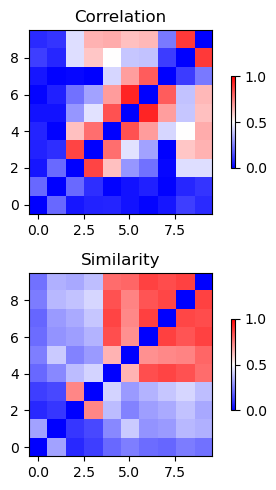

In [19]:
fig, ax = subplots(nrows=2, figsize=(4,5))

# Voltage matrices
im = ax[0].imshow(data_chan_seg_corr_abs, cmap='bwr', origin='lower', vmax=1);
fig.colorbar(im, ax=ax[0], ticks=(0, 0.5, 1), shrink = 0.5);
ax[0].set_title('Correlation')

im = ax[1].imshow(data_chan_seg_sim, cmap='bwr', origin='lower', vmax=1);
fig.colorbar(im, ax=ax[1], ticks=(0, 0.5, 1), shrink = 0.5);
ax[1].set_title('Similarity');

fig.tight_layout()

show()


In [20]:
######## Correlation
data_chan_seg_corr_1 = corrcoef(data_chan_seg[:rows_seg//2, :], rowvar=False)
data_chan_seg_corr_2 = corrcoef(data_chan_seg[rows_seg//2:, :], rowvar=False)

fill_diagonal(data_chan_seg_corr_1, 0)
fill_diagonal(data_chan_seg_corr_2, 0)

data_chan_seg_corr_abs_1      = abs(data_chan_seg_corr_1)
data_chan_seg_corr_abs_2      = abs(data_chan_seg_corr_2)

######## Jensen-Shannon
bins = 10

# Voltage
data_1, data_2 = data_chan_seg_norm[:rows_seg//2, :], data_chan_seg_norm[rows_seg//2:, :]

data_probs_1 = get_probabilities(data_1, bins)
data_probs_2 = get_probabilities(data_2, bins)

dist_matrix_1 = zeros(shape=(chans, chans))
dist_matrix_2 = zeros(shape=(chans, chans))


mat_indices = triu_indices(chans-1)

for ind, num_1 in enumerate(mat_indices[0]):

    num_2 = mat_indices[1][ind]+1
        
    dist_1      = jensen_shannon_distance(data_probs_1[num_1, :], data_probs_1[num_2, :])
    dist_2      = jensen_shannon_distance(data_probs_2[num_1, :], data_probs_2[num_2, :])
     
    dist_matrix_1[num_1, num_2] = dist_1
    dist_matrix_2[num_1, num_2] = dist_2

data_chan_seg_dist_1 = dist_matrix_1 + triu(dist_matrix_1).T
data_chan_seg_dist_2 = dist_matrix_2 + triu(dist_matrix_2).T

data_chan_seg_sim_1 = 1 - data_chan_seg_dist_1
data_chan_seg_sim_2 = 1 - data_chan_seg_dist_2

fill_diagonal(data_chan_seg_sim_1, 0)
fill_diagonal(data_chan_seg_sim_2, 0)


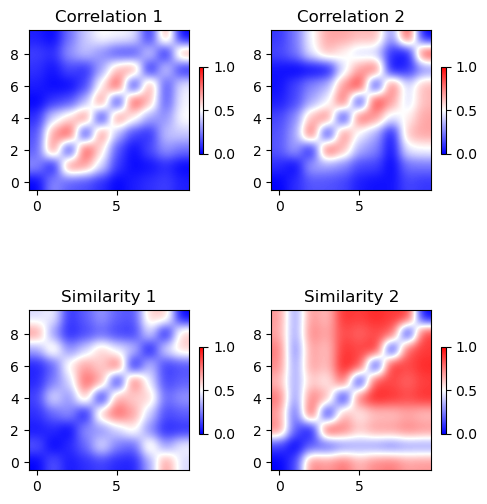

figs/02/B_half_matrices_L1_H20_Start60000.png



In [24]:
################################### Matrices
fig, ax = subplots(nrows=2, ncols=2, figsize=(5, 6))

# Voltage correlations
im = ax[0,0].imshow(data_chan_seg_corr_abs_1, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
fig.colorbar(im, ax=ax[0,0], ticks=(0, 0.5, 1), shrink = 0.3);
ax[0,0].set_title('Correlation 1')

im = ax[0,1].imshow(data_chan_seg_corr_abs_2, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
fig.colorbar(im, ax=ax[0,1], ticks=(0, 0.5, 1), shrink = 0.3);
ax[0,1].set_title('Correlation 2')

# Voltage similarities
im = ax[1,0].imshow(data_chan_seg_sim_1, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
fig.colorbar(im, ax=ax[1,0], ticks=(0, 0.5, 1), shrink = 0.3);
ax[1,0].set_title('Similarity 1')

im = ax[1,1].imshow(data_chan_seg_sim_2, cmap='bwr', origin='lower', vmax=1, interpolation='Gaussian');
fig.colorbar(im, ax=ax[1,1], ticks=(0, 0.5, 1), shrink = 0.3);
ax[1,1].set_title('Similarity 2')

fig.tight_layout()

show()

title_chars = 'figs/' + seizure + '/' + elec_name + '_half_matrices_' + 'L' + str(band_low) + '_H' + str(band_high) + '_Start' + str(seg_start) + '.png'
# fig.savefig(title_chars, format='png')
print(title_chars)
print('')

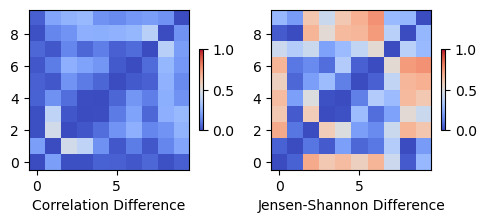

In [23]:
corr_diff = abs(data_chan_seg_corr_abs_2 - data_chan_seg_corr_abs_1)
js_diff   = abs(data_chan_seg_sim_2 - data_chan_seg_sim_1)

fig, ax = subplots(ncols=2, figsize = (5, 3))

im1 = ax[0].imshow(corr_diff, cmap='coolwarm', vmin=0, vmax=1, origin='lower');

im2 = ax[1].imshow(js_diff, cmap='coolwarm', vmin=0, vmax=1, origin='lower');

fig.colorbar(im1, ax=ax[0], orientation='vertical', shrink=0.3);
fig.colorbar(im2, ax=ax[1], orientation='vertical', shrink=0.3);

corr_title_data = 'Correlation Difference'
sims_title_data = 'Jensen-Shannon Difference'

ax[0].set_xlabel(corr_title_data)
ax[1].set_xlabel(sims_title_data)

fig.tight_layout()

title_chars = folder + 'figs/' + seizure + '_correlation_difference.png'
# fig.savefig(title_chars, format='png')
title_chars
print('')

show()


# Summary

- EEG is integral over extracellular currents in complex brain tissue (neurons, glia, blood vessels)
- EEG is organised in spatio-temporal patterns
- Normal Dynamics: irregular in frequency; small in amplitude; non-specific waveform
- Epileptic Dynamics: more regular frequency; often large amplitude; charactersitic waveforms.


# Try It Yourself

> Display data from different electrodes and pick different segments to re-run the code. You will be able to find segments with strongly contrasting types of dynamics. If you achieve to adjust the half segments, you will be able to maimise the contrast in univariate measures. 
